<a href="https://colab.research.google.com/github/noelmtv/Colab-Learning/blob/main/Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Import libraries#
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
!pip install fredapi



In [8]:
#define the list of tickers#
tickers = [
    "CSX", "UNP", "NSC","CP","CNI","RAIL","FSTR","TRN","GBX","WAB"
]


In [9]:
#SET THE END DATE TO TODAY#
end_date = datetime.today()

In [10]:
#Set start date#
start_date = end_date - timedelta(days=10*365)
print(start_date)

2015-03-19 04:40:31.944901


In [11]:
#download adjusted close prices#
#This is done because you dont want to underweight a stock that pays out dividends#
adj_close_df = pd.DataFrame()
print(adj_close_df.columns)

RangeIndex(start=0, stop=0, step=1)


In [12]:
# Download the prices for each ticker#
#yFinance has by default adjusted Open/High/Low/Close, hence no need to specify 'Adj Close'
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
print(adj_close_df)

                  CSX         UNP         NSC         CP        CNI  \
Date                                                                  
2015-03-19   9.918314   93.932808   88.392929  34.334972  59.463303   
2015-03-20  10.035333   93.852890   88.489090  34.655849  59.910213   
2015-03-23   9.618619   90.121147   85.388008  33.997608  58.920021   
2015-03-24   9.635745   89.905388   84.995361  34.250629  59.962791   
2015-03-25   9.507309   88.554916   83.376701  33.846649  59.033951   
...               ...         ...         ...        ...        ...   
2025-03-10  30.650000  248.289993  239.100006  74.309998  98.150002   
2025-03-11  29.520000  237.779999  232.979996  73.089996  95.459999   
2025-03-12  29.549999  237.490005  230.960007  74.120003  96.879997   
2025-03-13  29.129999  234.289993  227.690002  72.750000  95.919998   
2025-03-14  30.010000  237.529999  232.300003  75.290001  97.699997   

                 RAIL       FSTR        TRN        GBX         WAB  
Date   

**Step 3: Calculate the Lognormal Returns**

In [14]:
#Calculate the Lognormal returns for each ticker#
#Use lognormal because the returns are additive#
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [15]:
#drop missing values#
log_returns = log_returns.dropna()

**Step 4: Calculate the Covariance Matrix**

In [16]:
#helps us calculate standard deviation/risk in the most optimal way possible#
# MULTIPLY BY 252 TO ANNUALISE THE DAILY RETURNS#

cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           CSX       UNP       NSC        CP       CNI      RAIL      FSTR  \
CSX   0.079770  0.053923  0.065171  0.050125  0.040860  0.043195  0.049077   
UNP   0.053923  0.065635  0.056584  0.046480  0.038692  0.041131  0.046389   
NSC   0.065171  0.056584  0.080164  0.050922  0.042462  0.045379  0.047911   
CP    0.050125  0.046480  0.050922  0.072859  0.047512  0.038719  0.040891   
CNI   0.040860  0.038692  0.042462  0.047512  0.052264  0.031489  0.035302   
RAIL  0.043195  0.041131  0.045379  0.038719  0.031489  0.517716  0.089394   
FSTR  0.049077  0.046389  0.047911  0.040891  0.035302  0.089394  0.285116   
TRN   0.051313  0.046985  0.050978  0.045665  0.038365  0.092460  0.071485   
GBX   0.055586  0.052446  0.058217  0.051400  0.041019  0.112775  0.083442   
WAB   0.045687  0.043431  0.046939  0.041174  0.034341  0.069719  0.062462   

           TRN       GBX       WAB  
CSX   0.051313  0.055586  0.045687  
UNP   0.046985  0.052446  0.043431  
NSC   0.050978  0.058217  0.04

**Section 5: Define portfolio Performance Metrics**

In [17]:
#calculate the portfolio standard deviation#
def standard_deviation(weights,cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [18]:
#Calculate Expected Returns using historical returns#
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [19]:
# calculate the Sharpe Ratio

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)


In [20]:
# Get and define your FRED API key from secrets tab in Colab
from google.colab import userdata
fred_api_key = userdata.get('fred_api_key')

# Get the risk free rate
from fredapi import Fred
fred = Fred(api_key = fred_api_key)
ten_year_treasury_rate = fred.get_series('GS10')/100

#Set the risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)


0.044500000000000005


In [21]:
#Define the function to minimize (Negative Sharpe Ratio)
# In the case of scipy, there is no direct method to find the maximum value of a function so you gotta flip it.

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

    print(neg_sharpe_ratio)

In [37]:
#Set the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0,0.5) for _ in range(len(tickers))]

In [38]:
#Set the initial weights
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [39]:
#optimize the weights to maximise the sharpe ratio

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_results.x

# Print the optimized weights
print("Optimized Weights:")
print(optimized_weights)

Optimized Weights:
[5.00000000e-01 4.03107971e-01 9.68920289e-02 0.00000000e+00
 0.00000000e+00 4.12305315e-16 5.25474255e-16 0.00000000e+00
 3.59578468e-16 0.00000000e+00]


**Analyse the optimal portfolio**

In [40]:
# Display the analytics of the optimal portfolio

for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimized_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal Portfolio Return: {optimal_portfolio_return:.4f}")
print(f"Optimal Portfolio Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

CSX: 0.5000
UNP: 0.4031
NSC: 0.0969
CP: 0.0000
CNI: 0.0000
RAIL: 0.0000
FSTR: 0.0000
TRN: 0.0000
GBX: 0.0000
WAB: 0.0000

Optimal Portfolio Return: 0.1024
Optimal Portfolio Volatility: 0.2526
Optimal Sharpe Ratio: 0.2293


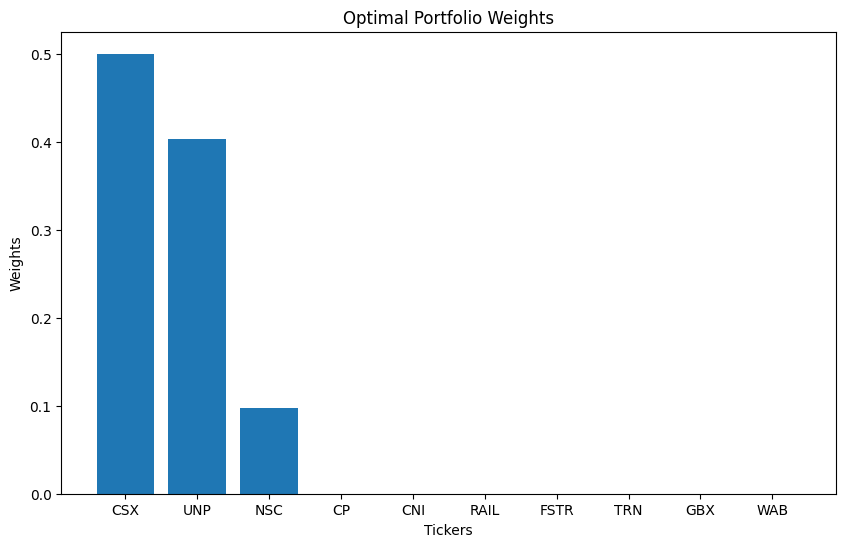

In [41]:
#display the final portfolio in a plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimized_weights)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights')
plt.show()